In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [100]:
datos = pd.DataFrame()

In [101]:
def transform_data(df: pd.DataFrame):
    # Crear la columna de fecha
    # df['Fecha'] = pd.to_datetime(df[['ANO', 'MES', 'DIA']], format='YYYY-MM-DD')

    df = df.rename(columns={'ANO': 'year', 'MES': 'month', 'DIA': 'day'})
    
    # Crear la columna de fecha correctamente
    df['Fecha'] = pd.to_datetime(df[['year', 'month', 'day']])

    # Filtrar las columnas de horas
    columnas_horas = [col for col in df.columns if col.startswith('H')]

    # Convertir el formato a filas
    df_melted = df.melt(id_vars=['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'Fecha'], 
                        value_vars=columnas_horas, 
                        var_name='Hora', 
                        value_name='Valor')

    # Convertir la columna 'Hora' a número de hora
    df_melted['Hora'] = df_melted['Hora'].str[1:].astype(int) - 1  # Eliminar 'H' y ajustar a formato de 24h
    return df_melted

In [102]:
def create_new_data(last_df: pd.DataFrame, next_df: pd.DataFrame):
    print('asd')
    # Extraer el mes y el día, ignorando el año
    last_df['Mes'] = last_df['Fecha'].dt.month
    last_df['Día'] = last_df['Fecha'].dt.day
    next_df['Mes'] = next_df['Fecha'].dt.month
    next_df['Día'] = next_df['Fecha'].dt.day

    # Hacer merge basado en Mes y Día
    merged_df = pd.merge(last_df, next_df, on=['Mes', 'Día'], suffixes=('_last', '_next'), how='left')

    # Calcular la media de la columna 'Valor'
    merged_df['Valor'] = merged_df[['Valor_last', 'Valor_next']].mean(axis=1)

    # Seleccionar solo las columnas necesarias
    mean_df = merged_df[['Fecha_last', 'Fecha_next', 'Valor']]  # Conservar ambas fechas originales

    display(mean_df)
    return mean_df

In [103]:
def fill_missing_values(df, column):
    # 1. Rellenar con la mediana del mismo día, mes y hora en otros años
    df[column] = df.groupby(["Mes", "Día", "Hora"])[column].transform(
        lambda x: x.fillna(x.median())
    )
    
    # 2. Si aún hay valores nulos, usar la mediana del mismo mes y hora en otros años
    df[column] = df.groupby(["Mes", "Hora"])[column].transform(
        lambda x: x.fillna(x.median())
    )
    
    # 3. Si aún quedan nulos, usar la mediana del mismo mes
    df[column] = df.groupby(["Mes"])[column].transform(
        lambda x: x.fillna(x.median())
    )
    
    return df

In [104]:
ruta = '../../../data/raw/madrid_data/horarios'
meses = ['ene', 'feb', 'mar', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic']
anhos = ['19', '20', '21', '22', '23', '24', '25']

In [105]:
lista_dfs = []

for anho in anhos:
    for mes in meses:
        try:
            file = f'{ruta}/20{anho}/{mes}_meteo{anho}.csv'
            print(f"Procesando: {file}")
            df = pd.read_csv(file, sep=';')

            # Verificar si el DataFrame tiene datos
            if df.empty:
                print(f"⚠️ Archivo vacío: {file}")
                continue  # Saltar al siguiente archivo

            # Transformar los datos
            df_transformado = transform_data(df)

            # Verificar si la transformación devuelve un DataFrame válido
            if isinstance(df_transformado, pd.DataFrame):
                lista_dfs.append(df_transformado)  # Agregar a la lista
            else:
                print(f"⚠️ Error en la transformación del archivo: {file}")

        except Exception as e:
            print(f"❌ ERROR al procesar {file}: {e}")

# Concatenar todos los DataFrames en uno solo
if lista_dfs:
    datos = pd.concat(lista_dfs, ignore_index=True)
else:
    print("⚠️ No se pudo cargar ningún archivo.")

Procesando: ../../../data/raw/madrid_data/horarios/2019/ene_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/feb_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/mar_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/may_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/jun_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/jul_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/ago_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/sep_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/oct_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/nov_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2019/dic_meteo19.csv
Procesando: ../../../data/raw/madrid_data/horarios/2020/ene_meteo20.csv
Procesando: ../../../data/raw/madrid_data/horarios/2020/feb_meteo20.csv
Procesando: ../../../data/raw/madrid_data/horarios/2020/mar_mete

In [106]:
datos.sort_values(by=['Hora', 'Fecha'], ascending=True, inplace=True)
datos

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,Fecha,Hora,Valor
0,28,79,102,81,28079102_81_98,2019-01-01,0,0.65
31,28,79,102,82,28079102_82_98,2019-01-01,0,64.00
62,28,79,102,83,28079102_83_98,2019-01-01,0,3.10
93,28,79,102,86,28079102_86_98,2019-01-01,0,50.00
124,28,79,102,87,28079102_87_98,2019-01-01,0,949.00
...,...,...,...,...,...,...,...,...
4120171,28,79,59,83,28079059_83_98,2025-01-31,23,3.80
4120202,28,79,59,86,28079059_86_98,2025-01-31,23,67.00
4120233,28,79,59,87,28079059_87_98,2025-01-31,23,948.00
4120264,28,79,59,88,28079059_88_98,2025-01-31,23,1.00


In [107]:
magnitudes_dict = {
    81: "VELOCIDAD VIENTO",
    82: "DIR. DE VIENTO",
    83: "TEMPERATURA",
    86: "HUMEDAD RELATIVA",
    87: "PRESION BARIOMETRICA",
    88: "RADIACION SOLAR",
    89: "PRECIPITACIÓN"
}

# Asegurar que los datos tengan los tipos correctos
datos["MAGNITUD"] = datos["MAGNITUD"].astype(int)
datos["Valor"] = pd.to_numeric(datos["Valor"], errors="coerce")

# Agregar la descripción de la magnitud
datos["MAGNITUD_DESC"] = datos["MAGNITUD"].map(magnitudes_dict)

# Filtrar solo por MUNICIPIO 79 y ESTACION 102
df_filtrado = datos[(datos["MUNICIPIO"] == 79) & (datos["ESTACION"] == 102)]

# Pivotar el DataFrame filtrado
df_pivotado = df_filtrado.pivot(index=["PROVINCIA", "MUNICIPIO", "ESTACION", "Fecha", "Hora"], 
                                columns="MAGNITUD_DESC", 
                                values="Valor").reset_index()

In [108]:
df_pivotado

MAGNITUD_DESC,PROVINCIA,MUNICIPIO,ESTACION,Fecha,Hora,DIR. DE VIENTO,HUMEDAD RELATIVA,PRECIPITACIÓN,PRESION BARIOMETRICA,RADIACION SOLAR,TEMPERATURA,VELOCIDAD VIENTO
0,28,79,102,2019-01-01,0,64.0,50.0,0.0,949.0,0.0,3.1,0.65
1,28,79,102,2019-01-01,1,32.0,49.0,0.0,949.0,0.0,2.9,0.95
2,28,79,102,2019-01-01,2,62.0,46.0,0.0,949.0,0.0,3.1,0.87
3,28,79,102,2019-01-01,3,75.0,51.0,0.0,949.0,0.0,1.9,0.73
4,28,79,102,2019-01-01,4,53.0,56.0,0.0,949.0,0.0,0.7,0.57
...,...,...,...,...,...,...,...,...,...,...,...,...
43651,28,79,102,2025-01-31,19,157.0,51.0,0.0,947.0,1.0,4.7,0.58
43652,28,79,102,2025-01-31,20,180.0,55.0,0.0,947.0,1.0,4.0,0.30
43653,28,79,102,2025-01-31,21,50.0,55.0,0.0,947.0,1.0,3.9,0.28
43654,28,79,102,2025-01-31,22,93.0,55.0,0.0,947.0,1.0,3.7,0.70


In [109]:
# Generar el rango de fechas y horas cada 1 hora
fecha_hora = pd.date_range(start='2019-01-01', end='2025-01-31', freq='1H')

# Crear un DataFrame con la fecha y la hora separadas
df_horario = pd.DataFrame({
    "Fecha": fecha_hora.date,  # Extrae solo la fecha
    "Hora": fecha_hora.hour    # Extrae solo la hora
})

# Asegurar que las columnas "Fecha" en ambos DataFrames sean del mismo tipo (datetime.date)
df_pivotado["Fecha"] = pd.to_datetime(df_pivotado["Fecha"]).dt.date

# Hacer la fusión con left join para mantener todas las horas incluso si faltan datos en df_pivotado
df_final = df_horario.merge(df_pivotado, how='left', on=['Fecha', 'Hora'])

C:\Users\linkiafp\AppData\Local\Temp\ipykernel_14932\4109931119.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fecha_hora = pd.date_range(start='2019-01-01', end='2025-01-31', freq='1H')


In [110]:
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

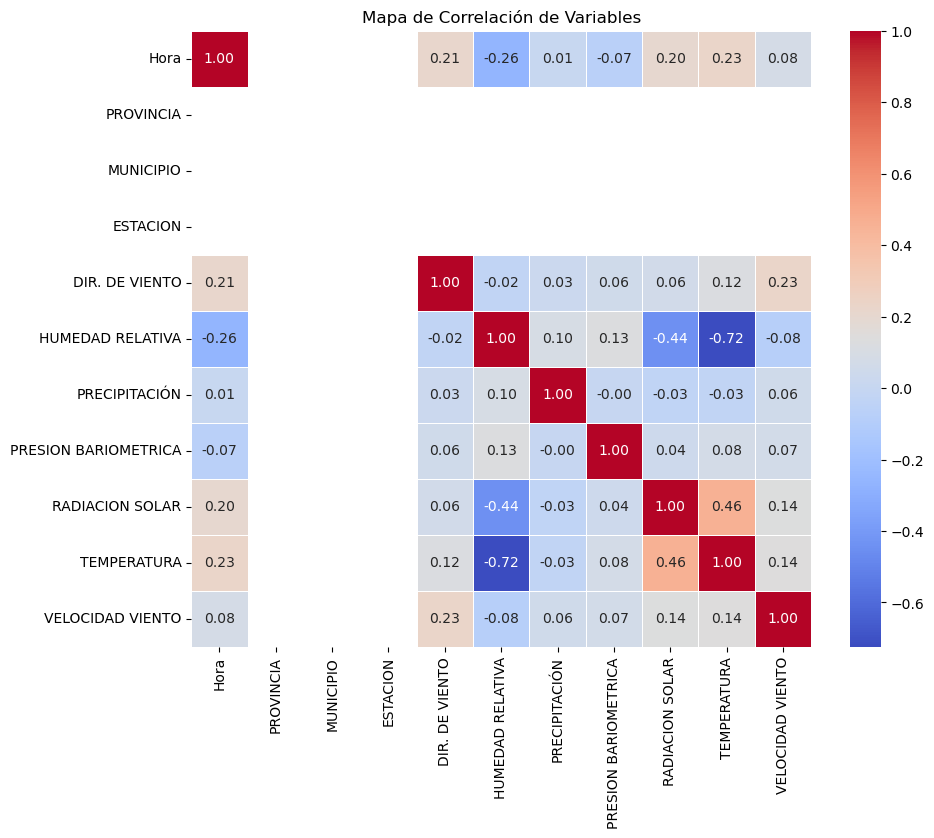

In [111]:
# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_final.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Correlación de Variables")
plt.show()

In [112]:
df_final.drop(columns=['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'PRESION BARIOMETRICA', 'DIR. DE VIENTO', 'VELOCIDAD VIENTO'], inplace=True)

In [113]:
df_final.isna().sum()

Fecha                  0
Hora                   0
HUMEDAD RELATIVA    9696
PRECIPITACIÓN       9696
RADIACION SOLAR     9696
TEMPERATURA         9696
dtype: int64

In [114]:
df_final

,Fecha,Hora,HUMEDAD RELATIVA,PRECIPITACIÓN,RADIACION SOLAR,TEMPERATURA
0,2019-01-01,0,50.0,0.0,0.0,3.1
1,2019-01-01,1,49.0,0.0,0.0,2.9
2,2019-01-01,2,46.0,0.0,0.0,3.1
3,2019-01-01,3,51.0,0.0,0.0,1.9
4,2019-01-01,4,56.0,0.0,0.0,0.7
...,...,...,...,...,...,...
53324,2025-01-30,20,46.0,0.0,1.0,3.4
53325,2025-01-30,21,50.0,0.0,1.0,2.5
53326,2025-01-30,22,50.0,0.0,1.0,2.4
53327,2025-01-30,23,52.0,0.0,1.0,2.0


In [115]:
df_final.describe()

,Fecha,Hora,HUMEDAD RELATIVA,PRECIPITACIÓN,RADIACION SOLAR,TEMPERATURA
count,53329,53329.000000,43633.000000,43633.000000,43633.000000,43633.00000
mean,2022-01-15 12:30:00.776313088,11.499784,53.272890,0.053572,200.424220,13.62108
min,2019-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,-9.10000
25%,2020-07-09 00:00:00,5.000000,34.000000,0.000000,0.000000,6.50000
50%,2022-01-16 00:00:00,11.000000,52.000000,0.000000,9.000000,12.40000
75%,2023-07-25 00:00:00,17.000000,72.000000,0.000000,358.000000,20.30000
max,2025-01-31 00:00:00,23.000000,100.000000,29.100000,1069.000000,37.90000
std,NaN,6.922366,23.319516,0.730727,288.486912,8.71191


In [116]:
print(df_final.dtypes)

Fecha               datetime64[ns]
Hora                         int32
HUMEDAD RELATIVA           float64
PRECIPITACIÓN              float64
RADIACION SOLAR            float64
TEMPERATURA                float64
dtype: object


In [117]:
columnas_a_rellenar = ["HUMEDAD RELATIVA", "PRECIPITACIÓN", "RADIACION SOLAR", "TEMPERATURA"]
df_filled = None
df_final["Año"] = df_final["Fecha"].dt.year
df_final["Mes"] = df_final["Fecha"].dt.month
df_final["Día"] = df_final["Fecha"].dt.day

for col in columnas_a_rellenar:
    df_filled = fill_missing_values(df_final, col)


In [118]:
df_filled.isna().sum()

Fecha                  0
Hora                   0
HUMEDAD RELATIVA    4320
PRECIPITACIÓN       4320
RADIACION SOLAR     4320
TEMPERATURA         4320
Año                    0
Mes                    0
Día                    0
dtype: int64

In [119]:
df_filled.to_csv('data.csv')